#### 00 The initial steps for filtering dataset for denoising

In [6]:
import doubletdetection
import scanpy as sc
import scipy.sparse as sp
import scanpy.external as sce
import numpy as np


In [1]:


context_path = "/home/sah2p/ondemand/singlecell_data/"
organism = 'Arabidopsis/'
adata = sc.read_h5ad(context_path+organism+"SRP166333.h5ad")


#### 01 Creating a New anndata objects with just raw data

In [4]:
# Create a new AnnData object with the raw counts
adata_raw = sc.AnnData(adata.raw.X.copy() if adata.raw is not None else adata.X.copy())

# Keep all obs columns except the specified ones
columns_to_remove = ['nCount_RNA', 'nFeature_RNA', 'Percent.mt', 'Seurat_clusters']
adata_raw.obs = adata.obs.drop(columns=columns_to_remove, errors='ignore')  # Remove specific columns

# Keep the original gene metadata (var)
adata_raw.var = adata.var.copy()  # Preserve all gene information

# Remove processed data that isn't needed
adata_raw.uns = {}  # Remove unstructured data
adata_raw.obsm = {}  # Remove dimensionality reductions (PCA, UMAP)
adata_raw.obsp = {}  # Remove pairwise distances
adata_raw.varm = {}  # Remove additional variable metadata

# Print summary to confirm
print(adata_raw)

AnnData object with n_obs × n_vars = 16949 × 53678
    obs: 'Orig.ident', 'Celltype', 'Dataset', 'Tissue', 'Organ', 'Condition', 'Genotype', 'Libraries', 'ACE'
    var: 'features'


#### 02 Perform Basic QC

	1.	Identify mitochondrial genes (in plants, these typically start with "ATMG" for Arabidopsis).
	2.	Calculate the percentage of mitochondrial genes per cell.
	3.	Filter out cells with high mitochondrial content.

Found 38 mitochondrial genes and 89 plastid genes.


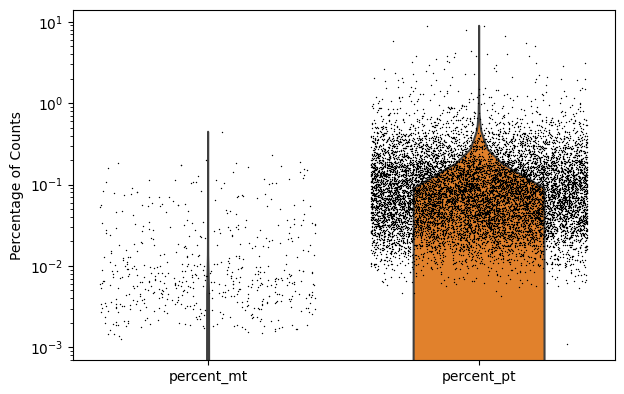

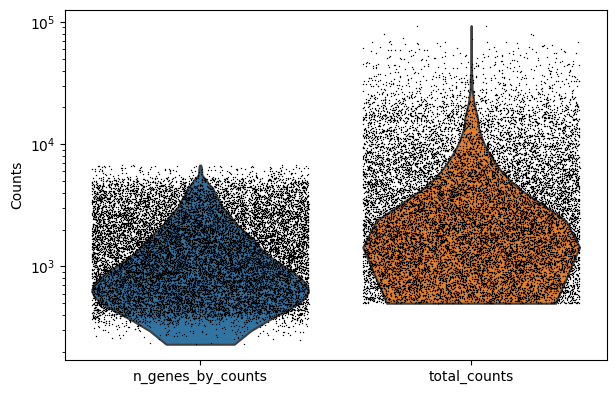

Remaining cells after filtering: 14279


In [5]:

# Identify mitochondrial and plastid genes
mt_genes = [gene for gene in adata_raw.var_names if gene.startswith("ATMG")]
pt_genes = [gene for gene in adata_raw.var_names if gene.startswith("ATCG")]
# Print the number of detected genes
print(f"Found {len(mt_genes)} mitochondrial genes and {len(pt_genes)} plastid genes.")

# Compute the fraction of mitochondrial gene counts per cell
adata_raw.obs["percent_mt"] = (
    np.sum(adata_raw[:, mt_genes].X, axis=1) / np.sum(adata_raw.X, axis=1)
) * 100

# Compute the fraction of plastid gene counts per cell
adata_raw.obs["percent_pt"] = (
    np.sum(adata_raw[:, pt_genes].X, axis=1) / np.sum(adata_raw.X, axis=1)
) * 100

adata_raw.obs["n_genes_by_counts"] = (adata_raw.X > 0).sum(axis=1)
# Compute total UMI counts per cell (nCount_RNA equivalent)
adata_raw.obs["total_counts"] = adata_raw.X.sum(axis=1)


# Visualize distributions before filtering
sc.pl.violin(adata_raw, ["percent_mt", "percent_pt"], jitter=0.4, log=True, ylabel="Percentage of Counts")
sc.pl.violin(adata_raw,["n_genes_by_counts","total_counts"], jitter=0.4, log=True, ylabel="Counts")


Q1 = np.percentile(adata_raw.obs["n_genes_by_counts"], 25)  # First quartile
Q3 = np.percentile(adata_raw.obs["n_genes_by_counts"], 75)  # Third quartile
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 6: Apply IQR-based filtering
adata_raw = adata_raw[
            (adata_raw.obs['percent_mt'] <= 10) &
            (adata_raw.obs['percent_pt'] <= 5) &
            (adata_raw.obs['n_genes_by_counts'] > lower_bound) &
            (adata_raw.obs['n_genes_by_counts'] < upper_bound) &
            (adata_raw.obs['total_counts'] > 200) &
            (adata_raw.obs['total_counts'] < 10000)]

# Step 7: Print summary after filtering
print(f"Remaining cells after filtering: {adata_raw.n_obs}")

#### 04 Doublet Detection

In [7]:

clf = doubletdetection.BoostClassifier(
    n_iters=10, 
    clustering_algorithm="louvain", 
    standard_scaling=True,
    pseudocount=0.1,
    n_jobs=-1,
)
doublets = clf.fit(adata_raw.X).predict(p_thresh=1e-16, voter_thresh=0.5)
doublet_score = clf.doublet_score()
adata_raw.obs["doublet"] = doublets
adata_raw.obs["doublet_score"] = doublet_score


  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_1869813/2416289682.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_raw.obs["doublet"] = doublets


In [17]:
adata_raw.obs["doublet"].value_counts()

0.0    14145
1.0      134
Name: doublet, dtype: int64

In [ ]:
sc.pl.violin(adata_raw, ["n_genes_by_counts"], jitter=0.4, log=True, ylabel="Percentage of Counts")

In [24]:
sc.tl.pca(adata_raw)  # Ensure PCA is computed
sc.pp.neighbors(adata_raw)  # Compute neighbors graph
sc.tl.umap(adata_raw)  # Compute UMAP
sc.pl.umap(adata_raw, color=["percent_mt", "percent_pt", "n_genes_by_counts"])

In [26]:
sc.pl.umap(adata_raw, color=["doublet", "doublet_score"])
adata_raw = adata_raw[adata_raw.obs['doublet'] == 0, :]



In [27]:
sc.pl.umap(adata_raw, color=["Orig.ident", "Condition"])

/home/sah2p/ondemand/tools/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sah2p/ondemand/tools/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


### Addressing batch effect

/home/sah2p/ondemand/tools/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sah2p/ondemand/tools/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sah2p/ondemand/tools/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


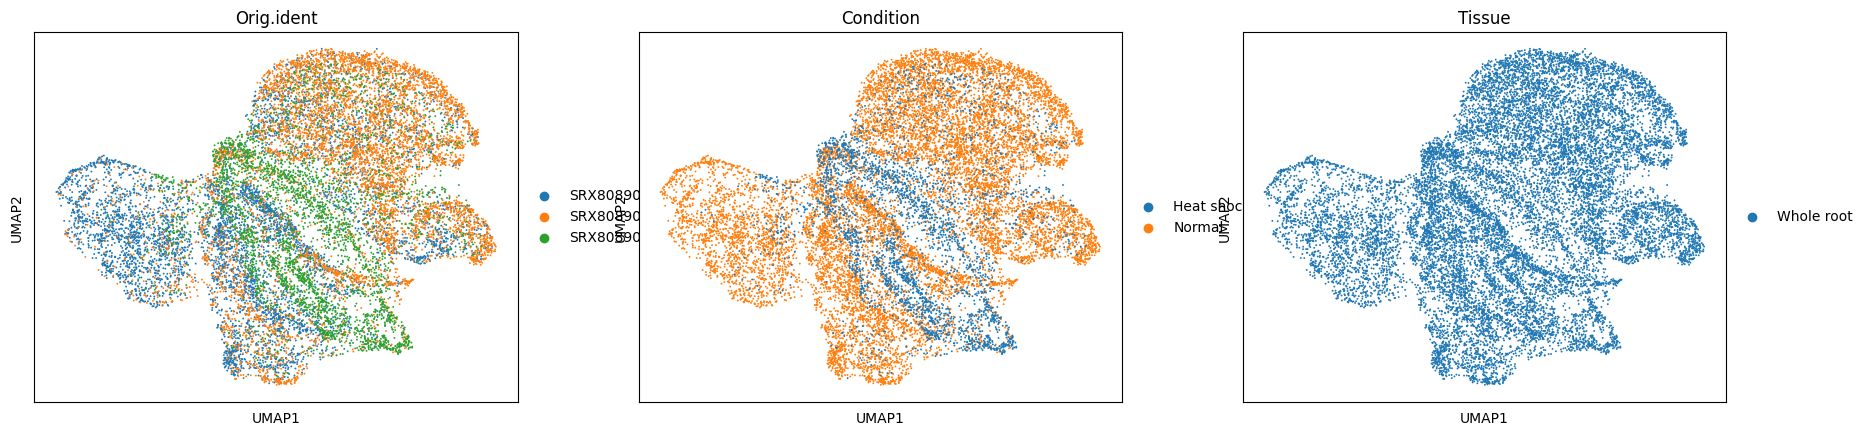

In [68]:
import scanpy.external as sce

sce.pp.bbknn(adata_raw, batch_key="Orig.ident")  # Adjusts batch effect
sc.tl.umap(adata_raw)

# Visualize after correction
sc.pl.umap(adata_raw, color=["Orig.ident", "Condition", "Tissue"])

In [79]:



#  batch column exists in adata.obs
batch_key = "Orig.ident"  # Change this to match your batch column in adata.obs

# Run Harmony
# `adata` is a variable that likely represents an Anndata object, which is a data structure commonly used in single-cell genomics analysis. It typically contains information about gene expression data, cell metadata, and other relevant information from single-cell experiments. In the provided code snippet, `adata` is being used to store and manipulate single-cell data, including running Harmony batch correction to remove batch effects, performing downstream analysis using the corrected data, and saving the corrected data to a file in H5AD format.
# Run Harmony
sce.pp.harmony_integrate(adata_raw, batch_key)
# Save corrected PCA representation
# Use Harmony-corrected PCA for downstream analysis
sc.pp.neighbors(adata_raw, use_rep="X_pca_harmony")
sc.tl.umap(adata_raw)
sc.tl.leiden(adata_raw)

# Save the corrected data
# adata.write_h5ad("your_data_harmony_corrected.h5ad")

2025-02-12 13:51:44,154 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


2025-02-12 13:51:56,999 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-02-12 13:51:57,102 - harmonypy - INFO - Iteration 1 of 10
2025-02-12 13:52:00,630 - harmonypy - INFO - Iteration 2 of 10
2025-02-12 13:52:04,018 - harmonypy - INFO - Iteration 3 of 10
2025-02-12 13:52:08,175 - harmonypy - INFO - Converged after 3 iterations


In [74]:
print(adata_raw.obsm["X_pca"].shape)

(16333, 50)


In [80]:
sce.pp.scanorama_integrate(adata_raw, batch_key, verbose=1)

Processing datasets SRX8089019 <=> SRX8089020
Processing datasets SRX8089020 <=> SRX8089021


In [81]:
adata_raw

AnnData object with n_obs × n_vars = 16333 × 53678
    obs: 'Orig.ident', 'Celltype', 'Dataset', 'Tissue', 'Organ', 'Condition', 'Genotype', 'Libraries', 'ACE', 'percent_mt', 'percent_pt', 'n_genes_by_counts', 'leiden'
    var: 'features'
    uns: 'pca', 'neighbors', 'umap', 'Orig.ident_colors', 'Condition_colors', 'Tissue_colors', 'Genotype_colors', 'leiden'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony', 'X_scanorama'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'